# Prostate cancer dataset with multiple overlapping field-of-views

We will see an example of to convert a complex multi-field-of-view dataset into Zarr. The converted data will be easier to visualize and analyze, and will contain all the information regarding the spatial alignments.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
from typing import Optional
import hashlib
import os
import zipfile
import PIL.Image
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dask_image.imread import imread
from spatialdata.models import Image2DModel, ShapesModel, TableModel
from spatialdata.transformations import Identity, Scale, get_transformation, set_transformation, align_elements_using_landmarks
from spatialdata import SpatialData, concatenate
from napari_spatialdata import Interactive
from spatial_image import SpatialImage
from anndata import AnnData
from spatialdata_io.readers._utils._read_10x_h5 import _read_10x_h5
from tqdm import tqdm
import spatialdata_plot

PIL.Image.MAX_IMAGE_PIXELS = None

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook performs some data conversion steps that are computational expensive. To make it easier to re-run this notebook without having to re-perform those task, we use a set of flags.

To run the full notebook, set all the flags to `False`. Running it should take ~1 hour, with most of the processing time due to the conversion of the large images.

In [3]:
RAW_DATA_ALREADY_UNZIPPED = True
IMAGES_ALREADY_CONVERTED = True
EXPRESSION_ALREADY_CONVERTED = True

## Overview of the raw data

Please manually download the data from https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/svw96g68dv-1.zip, and make it accesible from this notebook by putting it in `./data/lundeberg`. You can also use symlinks to make that path available to this notebook.

In [4]:
LUNDEBERG_DATA_ROOT = "data/lundeberg"
path = os.path.join(LUNDEBERG_DATA_ROOT, "svw96g68dv-1.zip")
assert os.path.isfile(path)

In [5]:
# unzip the data
unzipped_path = path.replace(".zip", "")
if not RAW_DATA_ALREADY_UNZIPPED:
    CHECKSUM = "eebd948d752a6d16b9c972e3fc4b293c4fa0fc16edbcbec41c8c5d48acf2143b"

    if hashlib.sha256(open(path, "rb").read()).hexdigest() != CHECKSUM:
        print("checksum mismatch")
    else:
        print("checksum ok")

    if not os.path.exists(unzipped_path):
        print("Unzipping the data")
        with zipfile.ZipFile(path) as zip_ref:
            zip_ref.extractall(os.path.dirname(unzipped_path))
        print("data unzipped")
    assert os.path.isdir(unzipped_path)

The dataset contains several files.

In [6]:
!tree $unzipped_path -L 1

data/lundeberg/svw96g68dv-1
├── Additional_figures
├── Count_matrices
├── DEG_analyses_lists_(Prostate_P1_H2_1)
├── Histological_images
├── SCC_patient
├── Stereoscope_cell_typ
├── Synthethic_data
├── WGS_SNP_prostate
├── inferCNV_pediatric_patient_1
└── p63_AMACR_stains_prostate

11 directories, 0 files


We will load and convert the following to NGFF:
* data layout schematics, from `Additional_figures`
* large H&E images for the Visium data (`patient1_visium`, `patient2_visium`) and for the 1K data (`patient1_1k`), from `Histological_images`
* Visium and 1k expression matrices, from `Count_matrices`

Together, the above data amounts for a large fraction of the files of the dataset.

In [7]:
!tree $unzipped_path

data/lundeberg/svw96g68dv-1
├── Additional_figures
│   ├── Patient_1_1k_Spatial_QC_Plot.png
│   ├── Patient_1_H1_1_&_V1_1_iCNV.png
│   ├── Patient_1_H2_1_Unsupervised_iCNV.png
│   ├── Patient_1_Visium_Spatial_QC_Plot.png
│   ├── Patient_1_Visium_Spot_Histology.png
│   ├── Patient_2_Visium_Spatial_QC_Plot.png
│   ├── Prostate_Patient_1.png
│   ├── Prostate_Patient_2.png
│   ├── SCC_smFISH_gain_of_1q_clones_A_B_C_and_normal_copy_clone_D_plus_amp.png
│   ├── SCC_smFISH_loss_of_8q_clones_A_B_D_normal_copy_clone_C.png
│   ├── Spatial_GEFs_Patient_1_1k.png
│   ├── Spatial_GEFs_Patient_1_Visium.png
│   └── Spatial_GEFs_Patient_2_Visium.png
├── Count_matrices
│   ├── Patient 1
│   │   ├── 1k_arrays
│   │   │   ├── H1_1
│   │   │   │   ├── 180822_L11_CN57_E1_H1.1_EB_stdata.tsv
│   │   │   │   └── spot_data-selection-180822_L11_CN57_E1_P_H1.1_CY3_EB_aliged.tsv
│   │   │   ├── H1_2
│   │   │   │   ├── 180903_L11_CN51_C2_H1.2_EB_stdata.tsv
│   │   │   │   └── spot_data-selection-180903_L11_CN51_C2

## Converting the images

### Layout images (small images)

In [8]:
layout_images = {
    'patient1_visium': os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_1_Visium.png"),
    'patient2_visium': os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_2_Visium.png"),
    "patient1_1k": os.path.join(unzipped_path, "Additional_figures/Spatial_GEFs_Patient_1_1k.png"),
    }

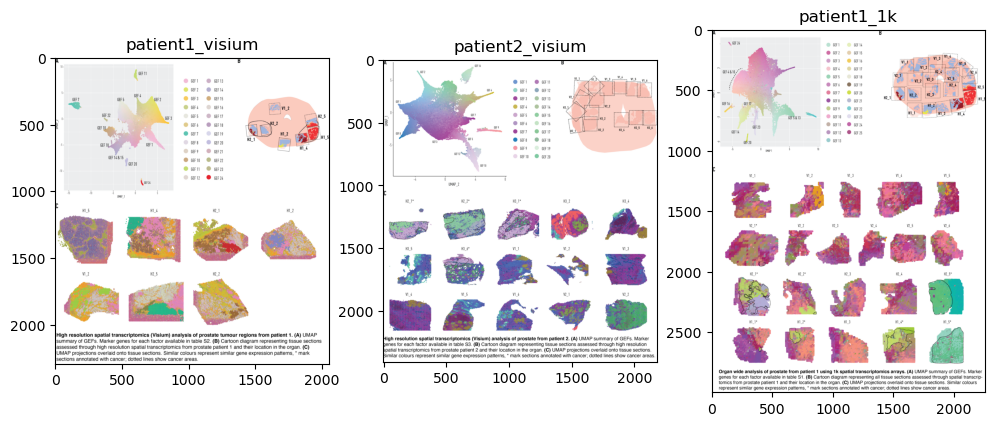

In [9]:
axes = plt.subplots(1, 3, figsize=(12, 5))[1].flatten()

for ax, (key, value) in zip(axes, layout_images.items()):
    im = np.squeeze(imread(value).compute(), 0)
    layout_images[key] = im
    ax.imshow(im)
    ax.set_title(key)

We are just interested in the schematics in the top right corner, let's crop the images. We manually identified the coordinates from an image viewer. You can for instance use napari, Fiji, Photoshop.

In [10]:
layout_images['patient1_visium'] = layout_images['patient1_visium'][293: 732, 1423: 2052]
layout_images['patient2_visium'] = layout_images['patient2_visium'][124: 750, 1426: 2181]
layout_images['patient1_1k'] = layout_images['patient1_1k'][176: 744, 1403: 2261]

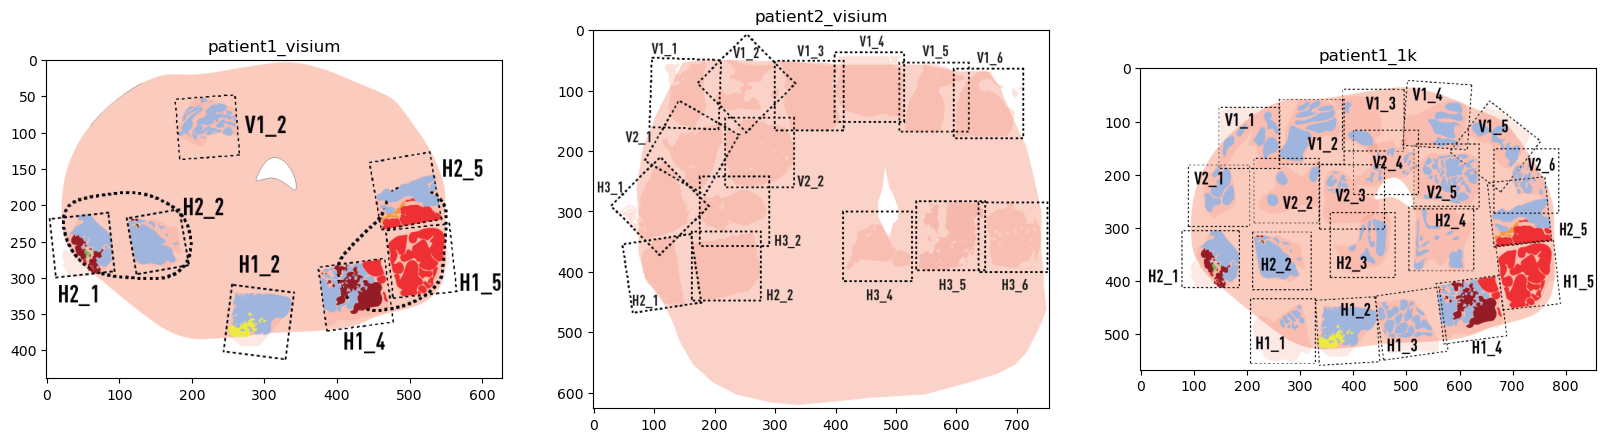

In [11]:
axes = plt.subplots(1, 3, figsize=(20, 5))[1].flatten()

for ax, (key, value) in zip(axes, layout_images.items()):
    ax.imshow(layout_images[key])
    ax.set_title(key)

### H&E images, `patient1_visium` (large images)

Here we will load large H&E images. We will use `dask_image.imread()` to be able to lazily represent the data even in a low-memory system (laptop).

In [12]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_1/Visium/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_1/Visium/", name)
            sample_name=name.replace(".jpg", "") + "_patient1_visium"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()})

            large_images[sample_name] = im

Now let's place the images, together with the small layout image, in a `SpatialData` object.

In [13]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(layout_images['patient1_visium'], dims=('y', 'x', 'c'), transformations={'patient1_visium': Identity()})
    sdata_patient1_visium = SpatialData(images=large_images | {'layout_patient1_visium': layout_image})

### H&E images, patient2_visium (large images)

In [14]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_2/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_2/", name)
            sample_name=name.replace(".jpg", "") + "_patient2_visium"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()})

            large_images[sample_name] = im

In [15]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(layout_images['patient2_visium'], dims=('y', 'x', 'c'), transformations={'patient2_visium': Identity()})
    sdata_patient2_visium = SpatialData(images=large_images | {'layout_patient2_visium': layout_image})

### H&E images, patient1_1k (large images)

In [16]:
if not IMAGES_ALREADY_CONVERTED:
    large_images = {}
    for name in tqdm(os.listdir(os.path.join(unzipped_path, "Histological_images/Patient_1/1k-array/"))):
        if name.endswith(".jpg"):
            path = os.path.join(unzipped_path, "Histological_images/Patient_1/1k-array/", name)
            sample_name=name.replace(".jpg", "") + "_patient1_1k"

            im = imread(path)
            im = im.squeeze()
            im = Image2DModel.parse(im, dims=("y", "x", "c"), scale_factors=[2, 2, 2, 2], transformations={sample_name: Identity()})

            large_images[sample_name] = im

In [17]:
if not IMAGES_ALREADY_CONVERTED:
    layout_image = Image2DModel.parse(layout_images['patient1_1k'], dims=('y', 'x', 'c'), transformations={'patient1_1k': Identity()})
    sdata_patient1_1k = SpatialData(images=large_images | {'layout_patient1_1k': layout_image})

### Saving to Zarr

Let's save the constructed `SpatialData` objects to Zarr, this will enable the representation of the data to be: multiscale, chunked and lazy. Practically, this will make possible to quickly open and explore the data in `napari`; we will use `napari` to annotate landmarks positions to align the data.

Converting the images to Zarr will require 10-40 min per dataset. Thanks to the `spatialdata` APIs we just have to do this once, because we can later on enrich the object with the expression data, and adjust the coordinate transformations.

In [18]:
OUT_FOLDER = os.path.join(LUNDEBERG_DATA_ROOT, "converted")
os.makedirs(OUT_FOLDER, exist_ok=True)

SDATA_PATIENT1_VISIUM_PATH = os.path.join(OUT_FOLDER, "patient1_visium.zarr")
SDATA_PATIENT2_VISIUM_PATH = os.path.join(OUT_FOLDER, "patient2_visium.zarr")
SDATA_PATIENT1_1K_PATH = os.path.join(OUT_FOLDER, "patient1_1k.zarr")

In [19]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT1_VISIUM_PATH):
        shutil.rmtree(SDATA_PATIENT1_VISIUM_PATH)

    sdata_patient1_visium.write(SDATA_PATIENT1_VISIUM_PATH)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


In [20]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT2_VISIUM_PATH):
        shutil.rmtree(SDATA_PATIENT2_VISIUM_PATH)

    sdata_patient2_visium.write(SDATA_PATIENT2_VISIUM_PATH)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


In [21]:
%%time
if not IMAGES_ALREADY_CONVERTED:
    if os.path.isdir(SDATA_PATIENT1_1K_PATH):
        shutil.rmtree(SDATA_PATIENT1_1K_PATH)

    sdata_patient1_1k.write(SDATA_PATIENT1_1K_PATH)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


### Final comments

Let's print the `SpatialData` objects that we constructed so far.

Let's reload the data from disk (for the case in which we skipped the cells above)

In [22]:
sdata_patient1_visium = SpatialData.read(SDATA_PATIENT1_VISIUM_PATH)
sdata_patient2_visium = SpatialData.read(SDATA_PATIENT2_VISIUM_PATH)
sdata_patient1_1k = SpatialData.read(SDATA_PATIENT1_1K_PATH)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Let's now look at some example images. Thanks to the multiscale representation we can quickly plot downscaled version of the imaes without having to load the full resolution versions.

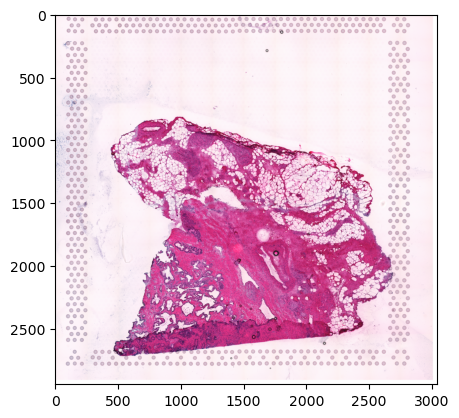

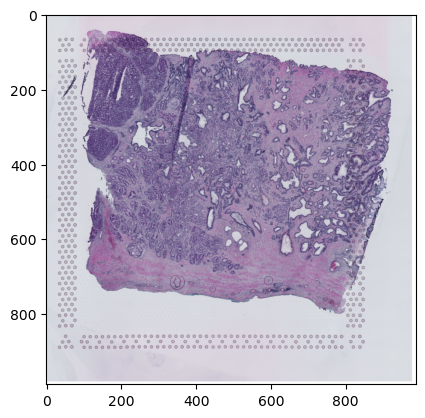

In [23]:
# TODO: this syntax will be less verbose once this bug is addressed: https://github.com/scverse/spatialdata/issues/223
plt.imshow(next(iter(sdata_patient1_visium['H1_1_patient1_visium']['scale4'].values())).transpose('y', 'x', 'c'))
plt.show()
plt.imshow(next(iter(sdata_patient1_visium['H1_4_patient1_visium']['scale4'].values())).transpose('y', 'x', 'c'))
plt.show()

## Adding the expression data

The 1k expression data doesn't come in standard format, so we need to parse it manually. The same is true for the Visium expression data; in fact for this dataset the data doesn't follow the standard output structure of SpaceRanger, so we can't use `spatialdata-io` for reading it. Also, the Visium data requires some ad-hoc adjustment to the coordiantes and the table annotations.

### Adding the Visium expression data

Let's start with Visium data and let's make a simple function to parse it.

In [24]:
def parse_visium_data(suffix: str, folder: str, excluded_images: set[str]) -> SpatialData:
    sdatas = []
    for name in os.listdir(folder):
        if name in excluded_images:
            continue
        DATASET_PATH = os.path.join(folder, name)

        COUNTS_MATRIX_PATH = os.path.join(DATASET_PATH, "filtered_feature_bc_matrix.h5")
        SCALE_FACTOR_JSON_PATH = os.path.join(DATASET_PATH, "scalefactors_json.json")
        TISSUE_POSITIONS_PATH = os.path.join(DATASET_PATH, "tissue_positions_list.csv")
        ANNOTATIONS_PATH = os.path.join(DATASET_PATH, f"{name}_Final_Consensus_Annotations.csv")

        assert os.path.isfile(COUNTS_MATRIX_PATH)
        assert os.path.isfile(SCALE_FACTOR_JSON_PATH)
        assert os.path.isfile(TISSUE_POSITIONS_PATH)

        # expression data
        region = f"{name}{suffix}_shapes"
        adata = _read_10x_h5(COUNTS_MATRIX_PATH)
        adata.obs["instance_id"] = adata.obs_names
        adata.obs["region"] = region
        adata.obs["region"] = adata.obs["region"].astype('category')
        table = TableModel.parse(
            adata, region=region, region_key="region", instance_key="instance_id"
        )
        table.var_names_make_unique()

        # scale factors
        with open(SCALE_FACTOR_JSON_PATH, "r") as infile:
            scalefactors = json.load(infile)

        # circles coordinates
        df = pd.read_csv(TISSUE_POSITIONS_PATH, header=None, index_col=0)
        df = df[df.index.isin(adata.obs_names)]
        coords = df.iloc[:, np.array([4, 3])].values
        
        # if we don't remove the index name the writing to Zarr fails
        df.rename_axis(None, inplace=True)

        if suffix == "_patient1_visium":
            transformation = Identity()
        elif suffix == "_patient2_visium":
            # the coordinates for patient2_visium require an extra scaling by 0.5
            transformation = Scale([0.5, 0.5], axes=("x", "y"))
        else:
            raise ValueError(f"Unknown suffix: {suffix}")
        circles = ShapesModel.parse(
            coords,
            geometry=0,
            radius=scalefactors["spot_diameter_fullres"] / 2.,
            index=df.index,
            transformations={f"{name}{suffix}": transformation},
        )

        # cell-type annotations, available only for patient 1
        if suffix == "_patient1_visium":
            assert os.path.isfile(ANNOTATIONS_PATH)
            annotations = pd.read_csv(ANNOTATIONS_PATH, index_col=0)
            annotations["Final_Annotations"] = annotations["Final_Annotations"].fillna("")
            annotations["Final_Annotations"] = annotations["Final_Annotations"].astype("str").astype("category")
            table.obs["Final_Annotations"] = annotations["Final_Annotations"]
        
        sdata = SpatialData(shapes={region: circles}, table=table)
        sdatas.append(sdata)
    c = concatenate(sdatas)
    return c

Not all the H&E images have associated expression, let's find out which one don't have it.

In [25]:
VISIUM_FOLDER_PATIENT1 = os.path.join(unzipped_path, "Count_matrices/Patient 1/Visium_with_annotation/")
VISIUM_FOLDER_PATIENT2 = os.path.join(unzipped_path, "Count_matrices/Patient_2/")

excluded_patient1 = set(os.listdir(VISIUM_FOLDER_PATIENT1)).symmetric_difference(
    set(name.replace("_patient1_visium", "") for name in sdata_patient1_visium.images.keys())
)
excluded_patient2 = set(os.listdir(VISIUM_FOLDER_PATIENT2)).symmetric_difference(
    set(name.replace("_patient2_visium", "") for name in sdata_patient2_visium.images.keys())
)

print(excluded_patient1)
print(excluded_patient2)

{'layout', 'H1_1', 'V1_1'}
{'V2_4', 'V2_6', 'H3_3', 'layout', 'H1_1', 'V2_5', 'H1_2', 'H2_6', 'H2_5', 'H1_3', 'V2_3', 'H1_4', 'H2_4', 'H2_3'}


In [26]:
if not EXPRESSION_ALREADY_CONVERTED:
    sdata_patient1_visium_expression = parse_visium_data(
        suffix="_patient1_visium", folder=VISIUM_FOLDER_PATIENT1, excluded_images=excluded_patient1
    )

    sdata_patient2_visium_expression = parse_visium_data(
        suffix="_patient2_visium", folder=VISIUM_FOLDER_PATIENT2, excluded_images=excluded_patient2
    )

We obtained new `SpatialData` objects, let's place the expression data in the ones that we previously constructed.

In [28]:
if not EXPRESSION_ALREADY_CONVERTED:
    # workaround for this https://github.com/scverse/spatialdata/issues/221, we will fix and remove this line
    sdata_patient1_visium_expression.table.obs['region'] = sdata_patient1_visium_expression.table.obs['region'].astype('category')
    sdata_patient1_visium.table.obs['Final_Annotations'] = sdata_patient1_visium.table.obs['Final_Annotations'].astype('category')
    sdata_patient2_visium_expression.table.obs['region'] = sdata_patient2_visium_expression.table.obs['region'].astype('category')

In [29]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in sdata_patient1_visium_expression.shapes.items():
        sdata_patient1_visium.add_shapes(name=k, shapes=v, overwrite=True)
        if sdata_patient1_visium.table is not None:
            del sdata_patient1_visium.table
        sdata_patient1_visium.table = sdata_patient1_visium_expression.table

In [30]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in sdata_patient2_visium_expression.shapes.items():
        sdata_patient2_visium.add_shapes(name=k, shapes=v, overwrite=True)
        if sdata_patient2_visium.table is not None:
            del sdata_patient2_visium.table
        sdata_patient2_visium.table = sdata_patient2_visium_expression.table

### Adding the 1k expressiond data (`patient1_1k`)

In [31]:
if not EXPRESSION_ALREADY_CONVERTED:
    ONE_K_FOLDER_PATIENT1 = os.path.join(unzipped_path, "Count_matrices/Patient 1/1k_arrays/")
    suffix = "_patient1_1k"
    sdatas = []
    for name in tqdm(os.listdir(ONE_K_FOLDER_PATIENT1)):
        DATASET_PATH = os.path.join(ONE_K_FOLDER_PATIENT1, name)
        files = os.listdir(DATASET_PATH)
        assert len(files) == 2
        expression_data_file = [f for f in files if f.endswith("_stdata.tsv")][0]
        positions_file = [f for f in files if not f.endswith("_stdata.tsv")][0]

        expression = pd.read_csv(os.path.join(DATASET_PATH, expression_data_file), sep="\t", index_col=0)
        positions = pd.read_csv(os.path.join(DATASET_PATH, positions_file), sep="\t", index_col=None)
        positions["instance_id"] = positions[["x", "y"]].apply(lambda x: f"{x['x']}x{x['y']}", axis=1)
        merged = pd.merge(positions, expression, left_on="instance_id", right_index=True, how="inner")
        positions_filtered = merged[positions.columns].copy()
        expression_filtered = merged[expression.columns].copy()

        adata = AnnData(expression_filtered, dtype=expression_filtered.values.dtype)
        adata.obs["instance_id"] = positions_filtered["instance_id"].to_numpy()
        assert adata.obs["instance_id"].is_unique
        
        region = f"{name}{suffix}_shapes"
        adata.obs["region"] = region
        adata.obs["region"] = adata.obs["region"].astype('category')
        
        table = TableModel.parse(adata, region=region, region_key='region', instance_key="instance_id")
        table.var_names_make_unique()

        coords = positions_filtered[["pixel_x", "pixel_y"]].values
        circles = ShapesModel.parse(
            coords,
            geometry=0,
            radius=50.,  # standard radius in micrometers of 1k data
            index=adata.obs["instance_id"],
            transformations={f'{name}{suffix}': Identity()},
        )
        sdata = SpatialData(shapes={region: circles}, table=table)
        sdatas.append(sdata)
    sdata_patient1_1k_expression = concatenate(sdatas)

The 1k expression data is in a new `SpatialData` object, let's place the data in the `SpatialData` object that we constructed previously.

In [33]:
if not EXPRESSION_ALREADY_CONVERTED:
    sdata_patient1_1k_expression.table.obs['region'] = sdata_patient1_1k_expression.table.obs['region'].astype('category')

In [34]:
if not EXPRESSION_ALREADY_CONVERTED:
    for k, v in tqdm(sdata_patient1_1k_expression.shapes.items()):
        sdata_patient1_1k.add_shapes(name=k, shapes=v, overwrite=True)
        if sdata_patient1_1k.table is not None:
            del sdata_patient1_1k.table
        sdata_patient1_1k.table = sdata_patient1_1k_expression.table

### Final comments

Let's look at the `SpatialData` objects that we constructed so far.

Let's reload the data from disk (for the case in which we skipped the cells above)

In [35]:
sdata_patient1_visium = SpatialData.read(SDATA_PATIENT1_VISIUM_PATH)
sdata_patient2_visium = SpatialData.read(SDATA_PATIENT2_VISIUM_PATH)
sdata_patient1_1k = SpatialData.read(SDATA_PATIENT1_1K_PATH)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Let's see the content of the `SpatialData` objects so far.

In [36]:
sdata_patient1_visium

SpatialData object with:
├── Images
│     ├── 'H1_1_patient1_visium': MultiscaleSpatialImage[cyx] (3, 47104, 48640), (3, 23552, 24320), (3, 11776, 12160), (3, 5888, 6080), (3, 2944, 3040)
│     ├── 'H1_2_patient1_visium': MultiscaleSpatialImage[cyx] (3, 13184, 13184), (3, 6592, 6592), (3, 3296, 3296), (3, 1648, 1648), (3, 824, 824)
│     ├── 'H1_4_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (3, 7910, 7910), (3, 3955, 3955), (3, 1977, 1977), (3, 988, 988)
│     ├── 'H1_5_patient1_visium': MultiscaleSpatialImage[cyx] (3, 13184, 13184), (3, 6592, 6592), (3, 3296, 3296), (3, 1648, 1648), (3, 824, 824)
│     ├── 'H2_1_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (3, 7910, 7910), (3, 3955, 3955), (3, 1977, 1977), (3, 988, 988)
│     ├── 'H2_2_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15667, 15821), (3, 7833, 7910), (3, 3916, 3955), (3, 1958, 1977), (3, 979, 988)
│     ├── 'H2_5_patient1_visium': MultiscaleSpatialImage[cyx] (3, 15821, 15821), (

In [37]:
sdata_patient2_visium

SpatialData object with:
├── Images
│     ├── 'H1_1_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_2_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_3_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H1_4_patient2_visium': MultiscaleSpatialImage[cyx] (3, 24258, 24000), (3, 12129, 12000), (3, 6064, 6000), (3, 3032, 3000), (3, 1516, 1500)
│     ├── 'H2_1_patient2_visium': MultiscaleSpatialImage[cyx] (3, 21221, 24000), (3, 10610, 12000), (3, 5305, 6000), (3, 2652, 3000), (3, 1326, 1500)
│     ├── 'H2_2_patient2_visium': MultiscaleSpatialImage[cyx] (3, 23242, 24000), (3, 11621, 12000), (3, 5810, 6000), (3, 2905, 3000), (3, 1452, 1500)
│     ├── 'H2_3_patient2_visium': MultiscaleSpatialImage[cyx] (3

In [38]:
sdata_patient1_1k

SpatialData object with:
├── Images
│     ├── 'H1_1_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_2_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_3_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_4_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H1_5_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H2_1_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 15872), (3, 7168, 7936), (3, 3584, 3968), (3, 1792, 1984)
│     ├── 'H2_2_patient1_1k': MultiscaleSpatialImage[cyx] (3, 28672, 31744), (3, 14336, 

TODO: replace the screenshots of napari with a plot made with `spatialdata-plot`

<img src="attachments/lundeberg_gene_expression.png" width="50%">
<img src="attachments/lundeberg_cell_types.png" width="50%">

## Aligning the images

### Aligning the 1k expression data to the corresponding images

Showing `H2_1_patient1_1k`.

### Aligning `patient1_visium` to `patient1_1k`

### Aligning the large images to the image layout (`patient1_visium`)

### Aligning the large images to the image layout (`patient2_visium`)

### Aligning the large images to the image layout (`patient1_1k`)